<a href="https://colab.research.google.com/github/zhpinkman/Variational-Auto-Encoder/blob/master/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
from tqdm import tqdm
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [202]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [203]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [204]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transform)

In [205]:
num_training_dataset = len(train_dataset)

In [206]:
train_data, val_data = random_split(train_dataset, [int(num_training_dataset*0.8), int(num_training_dataset*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [207]:
for data, target in train_loader:
    print(data.shape)
    print(target.shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])


### Encoder part of the VAE

In [208]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32 + 10, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x, c):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = torch.cat([x, c], -1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

### Decoder part of the VAE

In [222]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims + 10, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x, c):
        x = torch.cat([x, c], -1)
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

### Merging the classes for encoder and decoder part

In [223]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x, c):
        x = x.to(device)
        z = self.encoder(x, c)
        return self.decoder(z, c)

In [276]:
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=298, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=14, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): Batch

In [277]:
def one_hot(labels, class_size=10):
    targets = torch.zeros(labels.shape[0], class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

In [278]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for index, (x, target) in enumerate(dataloader): 
        # Move tensor to the proper device
        x = x.to(device)
        c = one_hot(target)
        x_hat = vae(x, c)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if index % 100 == 0:
            print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [279]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, target in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            c = one_hot(target)

            x_hat = vae(x, c)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [280]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      target = one_hot(np.array([test_dataset[i][1]]))
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img, target), target)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 40174.027344
	 partial train loss (single batch): 17220.429688

 EPOCH 1/10 	 train loss 78.641 	 val loss 51.453


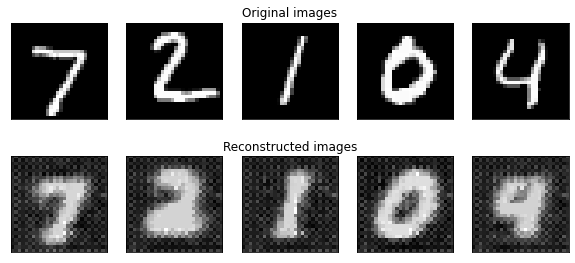

	 partial train loss (single batch): 13123.984375
	 partial train loss (single batch): 11873.435547

 EPOCH 2/10 	 train loss 46.998 	 val loss 43.953


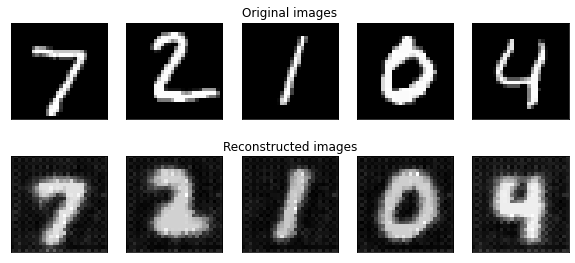

	 partial train loss (single batch): 11201.462891
	 partial train loss (single batch): 11054.940430

 EPOCH 3/10 	 train loss 43.107 	 val loss 41.782


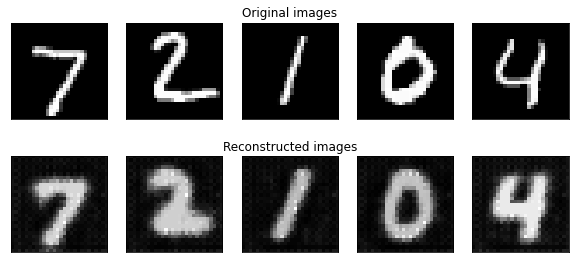

	 partial train loss (single batch): 10619.107422
	 partial train loss (single batch): 10634.940430

 EPOCH 4/10 	 train loss 41.346 	 val loss 40.363


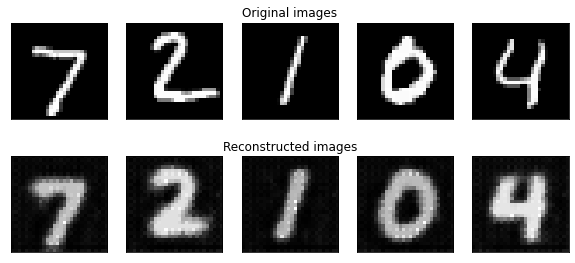

	 partial train loss (single batch): 10257.295898
	 partial train loss (single batch): 10240.145508

 EPOCH 5/10 	 train loss 39.811 	 val loss 38.736


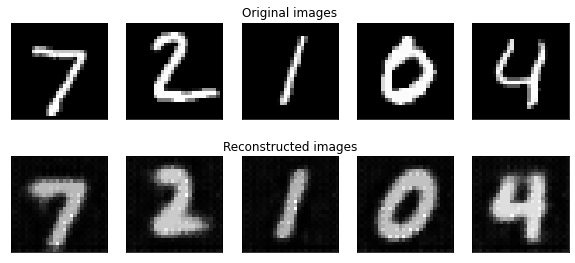

	 partial train loss (single batch): 9841.073242
	 partial train loss (single batch): 9871.421875

 EPOCH 6/10 	 train loss 38.263 	 val loss 37.388


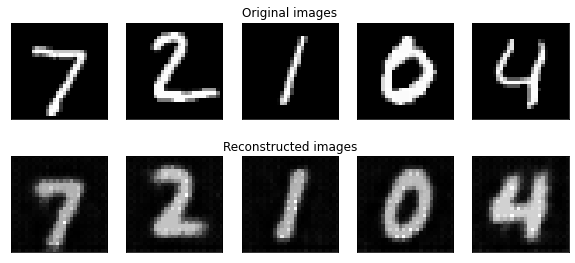

	 partial train loss (single batch): 9498.002930
	 partial train loss (single batch): 9496.758789

 EPOCH 7/10 	 train loss 36.929 	 val loss 36.176


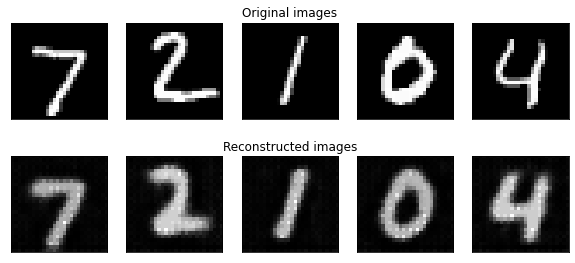

	 partial train loss (single batch): 9244.975586
	 partial train loss (single batch): 9193.837891

 EPOCH 8/10 	 train loss 35.733 	 val loss 34.932


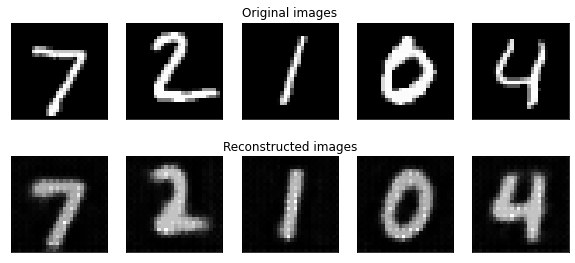

	 partial train loss (single batch): 8877.213867
	 partial train loss (single batch): 8870.371094

 EPOCH 9/10 	 train loss 34.681 	 val loss 34.043


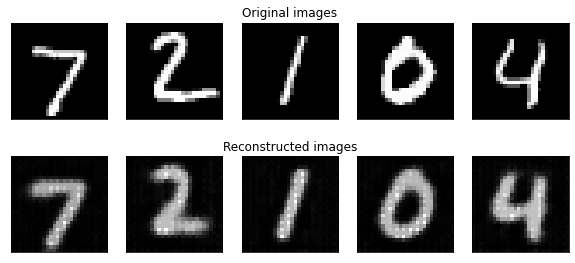

	 partial train loss (single batch): 8662.421875
	 partial train loss (single batch): 8670.146484

 EPOCH 10/10 	 train loss 33.701 	 val loss 32.995


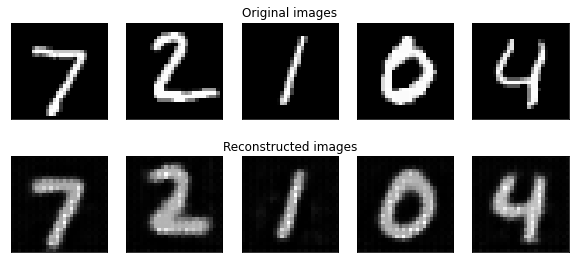

In [281]:
num_epochs = 10

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

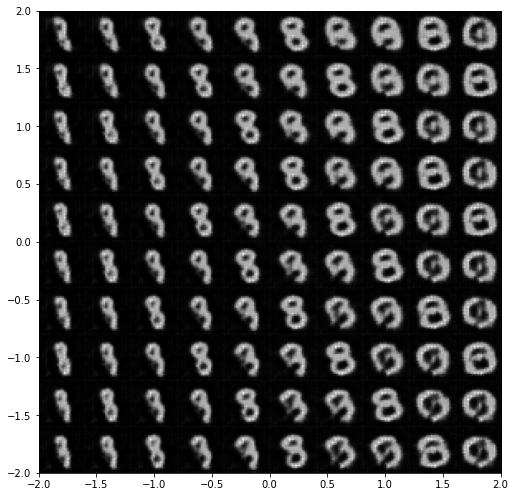

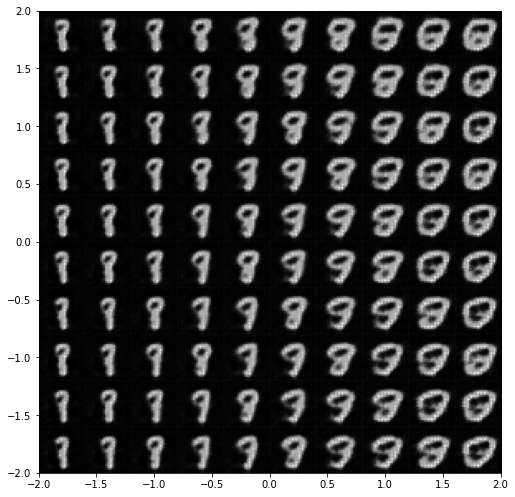

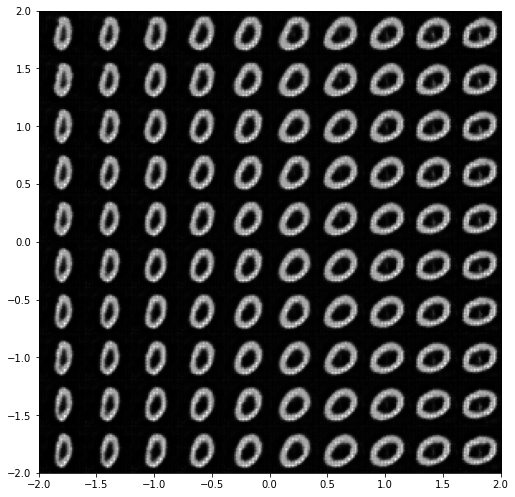

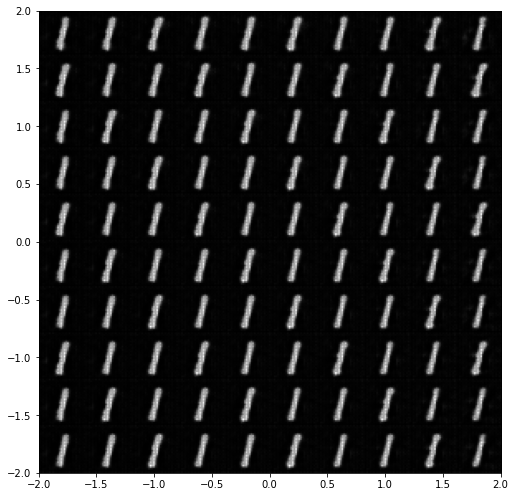

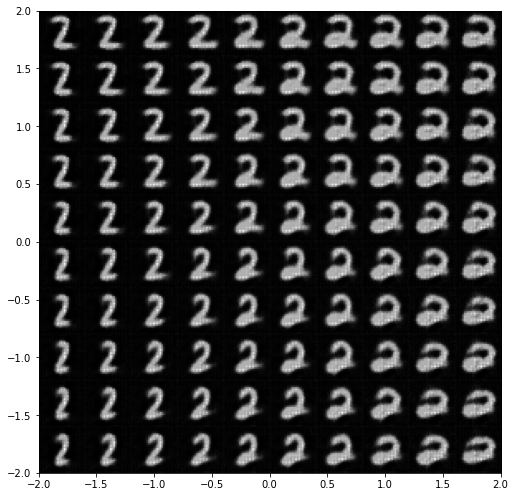

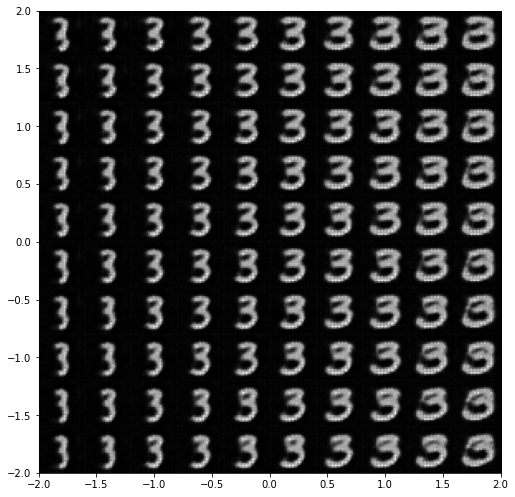

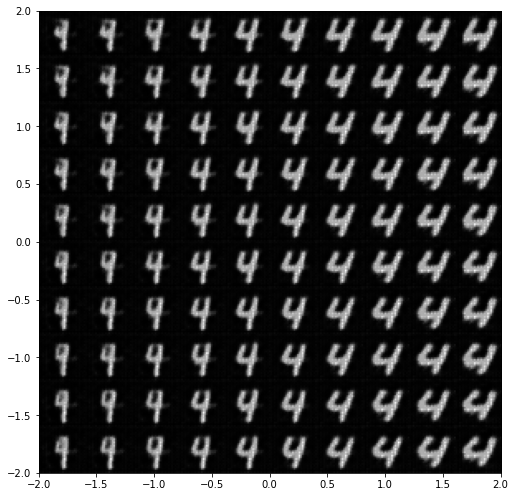

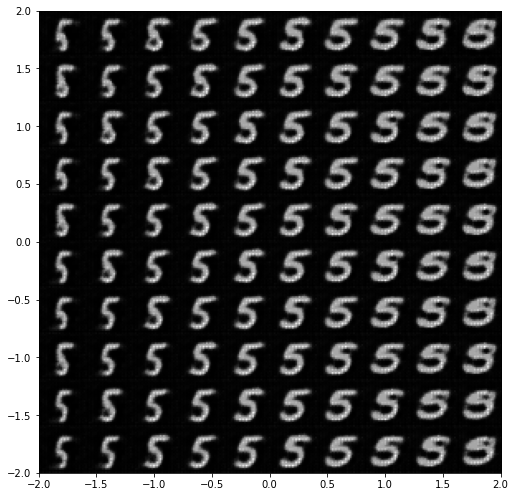

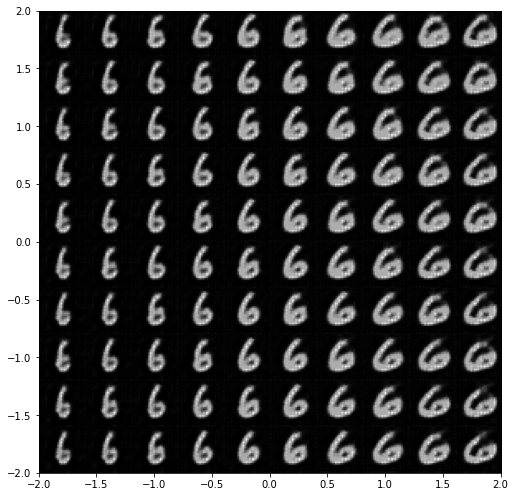

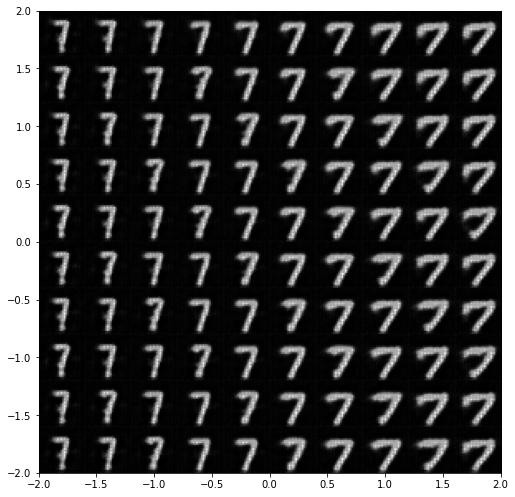

In [288]:
def plot_reconstructed(target, decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            c = one_hot(np.array([target]))
            x_hat = decoder(z, c)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')
    
for i in range(10):
    plot_reconstructed(i, vae.decoder, r0=(-2, 2), r1=(-2, 2)) 

In [289]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        c = one_hot(np.array([label]))
        encoded_img  = vae.encoder(img, c)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 10000/10000 [00:20<00:00, 493.40it/s]
